## Detecting Parkinsonâ€™s Disease with the help of deep learning

In [ ]:
# Get the fastai libraries and other important stuff: https://course.fast.ai/start_colab.html
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [ ]:
# Authenticate Colab to use my Google Drive for data storage and retrieval
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Parkinson'

In [ ]:
base_dir

'/content/gdrive/My Drive/Parkinson'

In [ ]:
# Tesla T4s, Yuhu!
!nvidia-smi

Tue Apr 30 07:44:24 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    32W /  70W |    967MiB / 15079MiB |      9%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
# Setting the path for getting the data
path = root_dir + 'Parkinsons/dataset'; path

'/content/gdrive/My Drive/Parkinsons/dataset'

In [ ]:
# A bunch of useful magic commands
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.metrics import *

In [ ]:
import numpy as np
np.random.seed(7)

### Loading and preparing the data with fastai's [`ImageDataBunch`](https://docs.fast.ai/vision.data.html#ImageDataBunch) class

In [ ]:
# Note that we are loading the images in the size of 128x128
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), valid='test',
                                  size=128, bs=8).normalize(imagenet_stats)

### Looking at the data

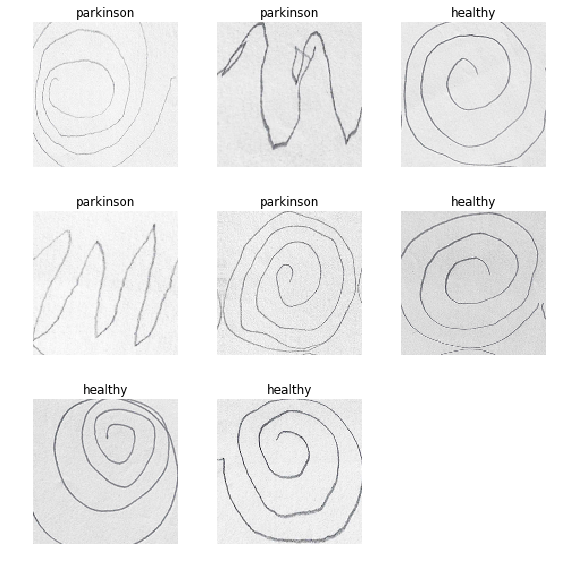

In [ ]:
data.show_batch(rows=3, figsize=(8,8))

### Data labels and distributions

In [ ]:
data.classes

['healthy', 'parkinson']

In [ ]:
data.label_list

LabelLists;

Train: LabelList (144 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
healthy,healthy,healthy,healthy,healthy
Path: /content/gdrive/My Drive/Parkinsons/dataset;

Valid: LabelList (60 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
parkinson,parkinson,parkinson,parkinson,parkinson
Path: /content/gdrive/My Drive/Parkinsons/dataset;

Test: None

### Beginning the model training process

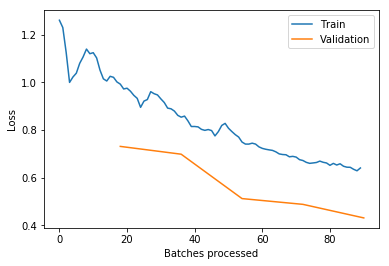

In [ ]:
# Training with mixed precision
learn = cnn_learner(data, models.resnet34, metrics=accuracy).to_fp16()
learn.fit_one_cycle(5);
learn.recorder.plot_losses()

**Training loss is greater than validation loss**. A clear sign of _underfitting_. Let's find a suitable learning rate for the model first. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


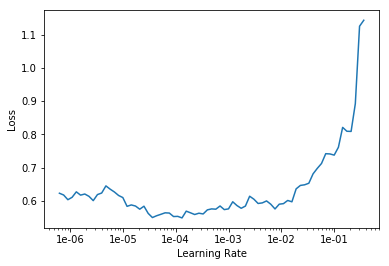

In [ ]:
learn.lr_find()
learn.recorder.plot()

We can now set a range of learning rate from the above plot. We will train the network using the learning rate just after which the model's loss starts to bump up. Let's start with `1e-04`. We will train the last layer with a smaller learning rate for effective convergence. We will also allow the network to learn a bit more since it is  _underfitting_ the data (with the help of the [`unfreeze()`](https://docs.fast.ai/basic_train.html#Learner.unfreeze) method.)</s>

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=1e-04)

The model does not **underfit** now. 

In [ ]:
# How about training the last group with a relatively lower learning rate?
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-04, 1e-04/5))

Performance improves, indeed. But the underfitting remains. Let's see what happended inside. 

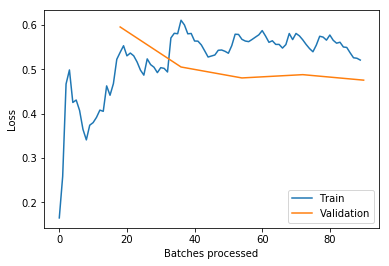

In [ ]:
learn.recorder.plot_losses()

In [ ]:
# Let's save the wait
learn.save('stage-1-rn34')

We will now interpret the model's performance so as to see its top losses. Fastai provides a handy [`ClassificationInterpretation`](https://docs.fast.ai/vision.learner.html#ClassificationInterpretation) class which makes this ridiculously easy. 

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

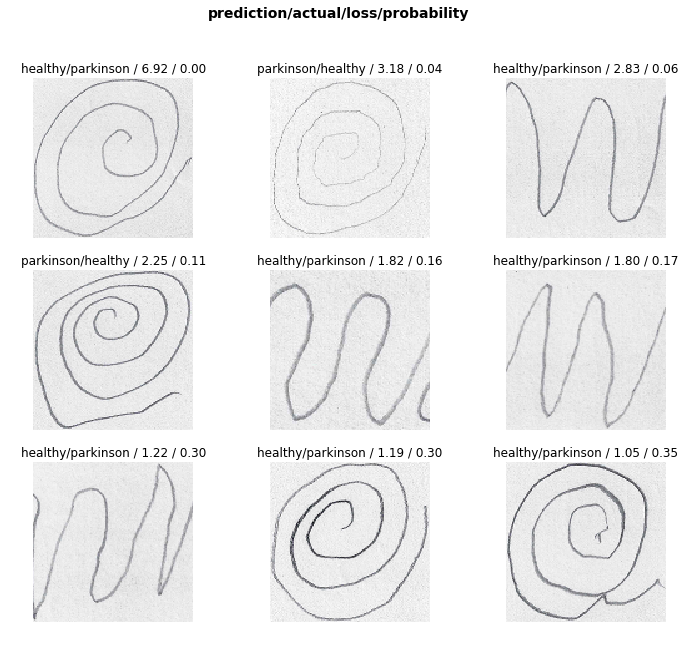

In [ ]:
interp.plot_top_losses(9, figsize=(12,10), heatmap=False)

**Observation**: I created the `ImageDatabunch` with a size of **128x128**. I think this is indeed confusing the model. The model is unable to explore the pixels in the images due to the reduced size. Let's do it with 256 this time and see if we can push the score and robustness. 

In [ ]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), valid='test',
                                  size=256, bs=8).normalize(imagenet_stats)

learn = cnn_learner(data, models.resnet34, metrics=accuracy).to_fp16()
learn.load('stage-1-rn34') # Loading the weights of the previous model
learn.fit(5)

The performance improved. Here, we fitted a model which was trained using images of size 128x128. Let's train a fresh model. 

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy).to_fp16()
learn.fit_one_cycle(5)

Let's find the network a good learning rate and also investigate the model training. 

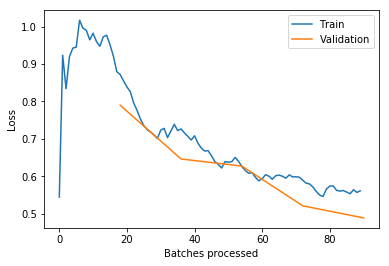

In [ ]:
learn.recorder.plot_losses()

Model's training loss keeps getting down which is a good sign. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


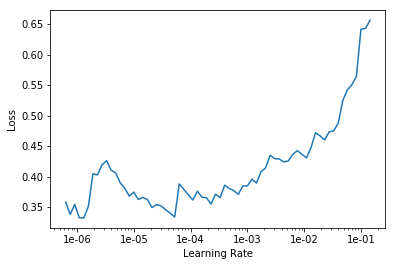

In [ ]:
learn.lr_find()
learn.recorder.plot()

Let's go with `1e-04`. We will also train the model a bit more. 

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-04, 1e-04/5))

In [ ]:
learn.save('rn-34-unfreeze')

Let's see how the learning rates and the losses are holding up now. 

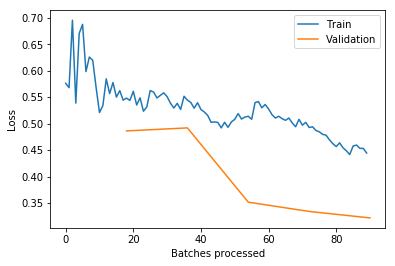

In [ ]:
learn.recorder.plot_losses()

 We can see that in the plot for the validation loss. We can also see the effect of the `fit_one_cycle()` method on the learning rate in the below plot. 

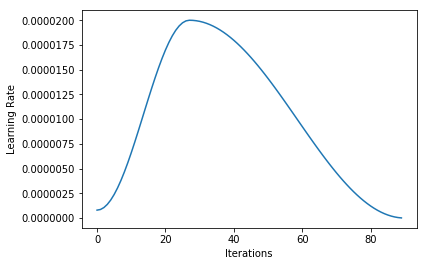

In [ ]:
learn.recorder.plot_lr()

As we see in the previous to previous plot the loss bumps a little bit towards the latter half of the training. So, let's try with `1e-05` this time. 

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(3*1e-05, 3*1e-05/5))

The final accuracy remains the same but the model does not underfit now. 

In [ ]:
learn.save('stage-2-rn34-256-final')

In [ ]:
learn.export('parkinson-predictor.pkl')

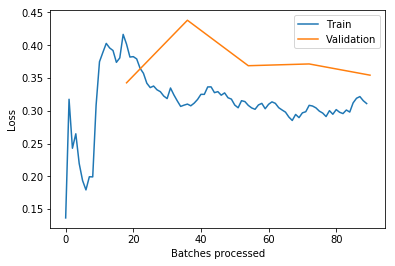

In [ ]:
learn.recorder.plot_losses()

Let's now interpret the model a bit by taking a look at its results, model's top losses and the confusion matrix . 

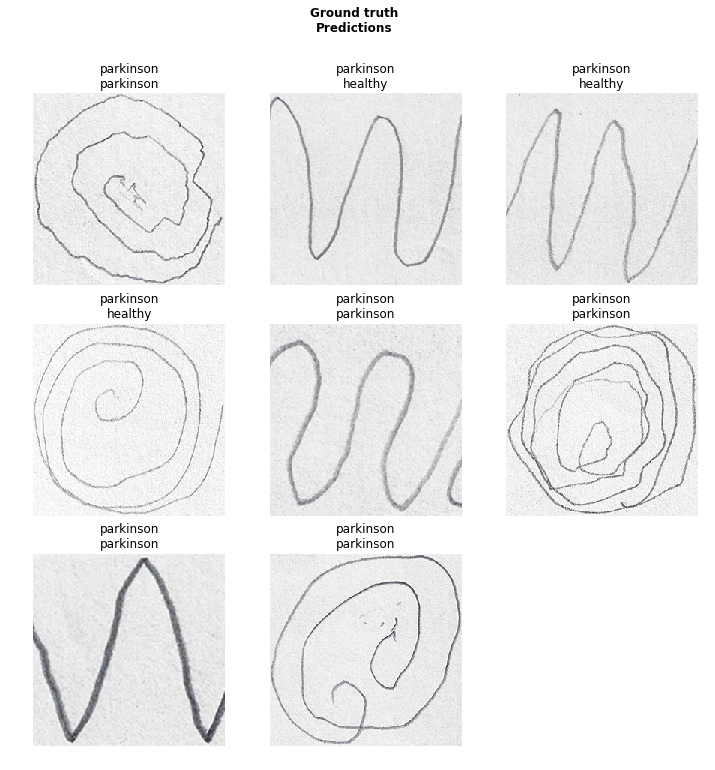

In [ ]:
# Model's predictions on the test set
learn.show_results(rows=3)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

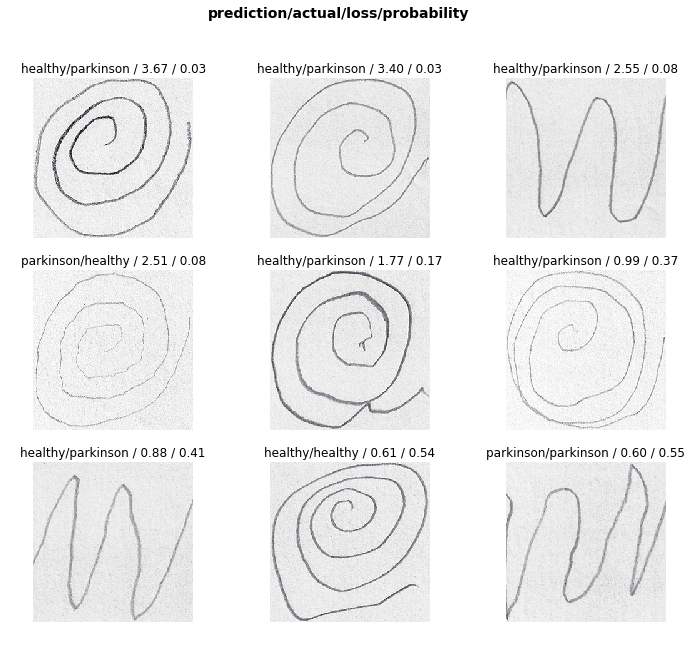

In [ ]:
# Images for the loss is maximum
interp.plot_top_losses(9, figsize=(12,10), heatmap=False)

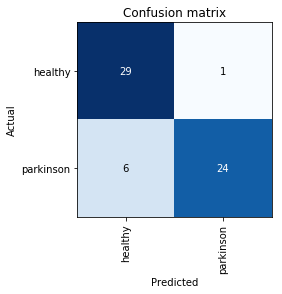

In [ ]:
interp.plot_confusion_matrix()

 The model performs pretty good in fact. 